In [1]:
"""--------------------------------------------------------------------------------------------------------
  
    Example correction of a frequency shifting in STORI analysis for CDMS
    
    Author: Mike Goodwin (mike.goodwin@thermofisher.com)
    
    Copyright (C) 2024 Thermo Fisher Scientific
 
    This software may be modified and distributed under the terms
    of the MIT license.  

-------------------------------------------------------------------------------------------------------"""

#import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import scipy
from scipy.fftpack import fft, ifft
from scipy.fft import rfft
from scipy.ndimage import uniform_filter1d

mpl.style.use('ggplot')

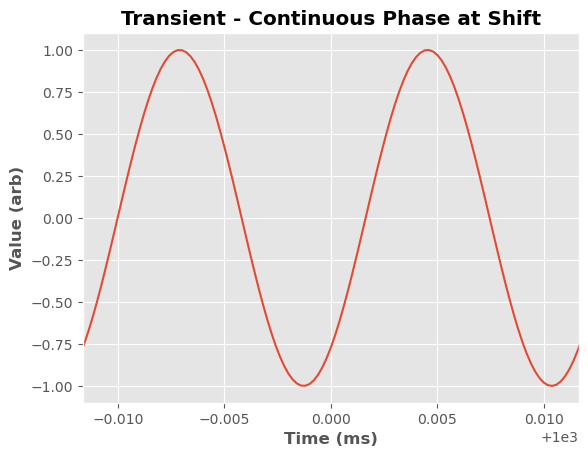

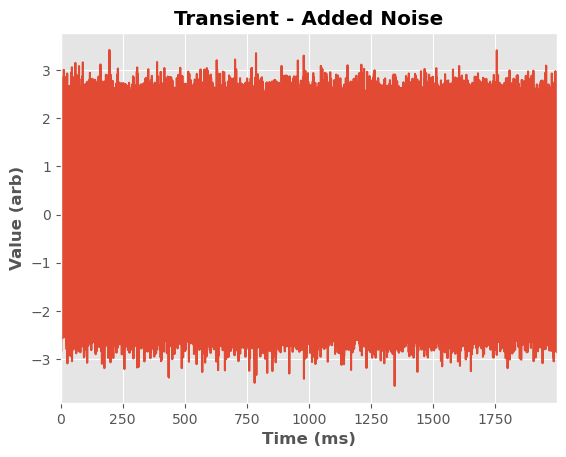


Finished generating transient.

Transient Length: 2.0 s
Sampling Frequency: 5.0 MHz
Noise Level: 0.5
Ion Amplitude: 1.0
Starting Frequency: 85.833860 kHz
Ending Frequency: 85.834053 kHz
Time of Shift: 1000.0 ms


In [2]:
"""--------------------------------------------------------------------------------------------------------

    STEP 1: GENERATE AN ARTIFICIAL TRANSIENT, WITH A SHIFT IN FREQUENCY HALFWAY THROUGH

-------------------------------------------------------------------------------------------------------"""

#General transient settings
transient_length_ms = 2000.0
noise = 0.5
time_step_us = 0.2

#Ion-specific settings
amplitude = 1.0
starting_frequency_kHz = 85.83386    #chose as a representative frequency for AAVs on a UHMR
frequency_shift_ppm = 2.25           #chose as roughly representative of neutral water loss from a 4.0 MDa AAV
frequency_shift_time_ms = 0.5*transient_length_ms     
frequency_shift_kHz = starting_frequency_kHz*frequency_shift_ppm/1.0e6     
ending_frequency_kHz = starting_frequency_kHz+frequency_shift_kHz

#arrays to hold time and amplitude for the transient
times_ms = np.arange(0.0,transient_length_ms,time_step_us/1000.0)
transient_values = np.zeros(times_ms.size)

"""--------------------------------------------------------------------------------------------------------
  We calculate how much the artificial ion signal's phase will be shifted after the frequency shift occurs.
  This is necessary to mimic the real world, in which the ion signal's phase will be continuous, even when
  its frequency jumps discretely.  
---------------------------------------------------------------------------------------------------------"""
phase_offset_after_shift = 2*np.pi*(ending_frequency_kHz-starting_frequency_kHz)*frequency_shift_time_ms

#get the time index where the change occurs
shift_index = math.floor(frequency_shift_time_ms/(time_step_us/1000.0))

#make the first part of the transient have the starting frequency
transient_values[0:shift_index] = amplitude*np.sin(2*np.pi*times_ms[0:shift_index]*starting_frequency_kHz)

#make the second part of the transient have the ending frequency, accounting for the phase offset
transient_values[shift_index:-1] = amplitude*np.sin(2*np.pi*times_ms[shift_index:-1]*ending_frequency_kHz-phase_offset_after_shift)


#Let's zoom in on the part of the transient where the frequency shift occurs, to show that phase is continuous
zoom_time_width_ms = 1/starting_frequency_kHz

plt.figure()
plt.plot(times_ms,transient_values)
plt.xlabel('Time (ms)', weight='bold')
plt.xlim(frequency_shift_time_ms-zoom_time_width_ms, frequency_shift_time_ms+zoom_time_width_ms)
plt.ylabel('Value (arb)', weight='bold')
plt.title('Transient - Continuous Phase at Shift', weight='bold')
plt.show()


#now that we have the pure ion signal, let's add noise to the transient
transient_values = transient_values + np.random.normal(0.0,noise,times_ms.size)

plt.figure()
plt.plot(times_ms,transient_values)
plt.xlabel('Time (ms)', weight='bold')
plt.xlim(np.min(times_ms), np.max(times_ms))
plt.ylabel('Value (arb)', weight='bold')
plt.title('Transient - Added Noise', weight='bold')
plt.show()


print('\nFinished generating transient.\n')
print('Transient Length: {:.1f} s'.format(transient_length_ms/1000.0))
print('Sampling Frequency: {:.1f} MHz'.format(1.0/time_step_us))
print('Noise Level: {:.1f}'.format(noise))
print('Ion Amplitude: {:.1f}'.format(amplitude))
print('Starting Frequency: {:.6f} kHz'.format(starting_frequency_kHz))
print('Ending Frequency: {:.6f} kHz'.format(ending_frequency_kHz))
print('Time of Shift: {:.1f} ms'.format(frequency_shift_time_ms))


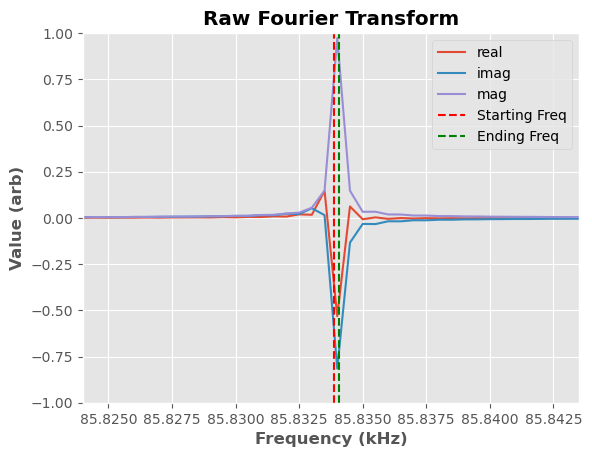

In [3]:
"""--------------------------------------------------------------------------------------------------------

    STEP 2: PERFORM A FOURIER TRANSFORM OF THE TRANSIENT

-------------------------------------------------------------------------------------------------------"""
        
if times_ms.size % 2 == 1:
    times_ms = times_ms[:-1]
    transient_values = transient_values[:-1]

sampling_time_s = time_step_us / 1000000;
sampling_frequency_Hz = 1 / sampling_time_s;

fftout = rfft(transient_values)
fftout = fftout/fftout.size
fftout[0]=0

max_freq_kHz = sampling_frequency_Hz/(2.0*1000.0)
frequency = np.linspace(0,max_freq_kHz, fftout.size)
freq_spacing_kHz = frequency[1]-frequency[0]
plot_width_kHz=0.01
plot_width_indices = int(plot_width_kHz/freq_spacing_kHz)
center_index = math.ceil(starting_frequency_kHz/freq_spacing_kHz)
plot_start_index = center_index - plot_width_indices
plot_end_index = center_index + plot_width_indices
plot_freqs = frequency[plot_start_index:plot_end_index]
plot_fftout = fftout[plot_start_index:plot_end_index]

#make a figure zoomed in on the peak of interest
plt.figure()
plt.plot(plot_freqs, np.real(plot_fftout),label='real')
plt.plot(plot_freqs, np.imag(plot_fftout),label='imag')
plt.plot(plot_freqs, np.abs(plot_fftout),label='mag')
plt.plot(np.asarray([starting_frequency_kHz,starting_frequency_kHz]), np.asarray([-amplitude,amplitude]), '--', color='red', label='Starting Freq')
plt.plot(np.asarray([ending_frequency_kHz,ending_frequency_kHz]), np.asarray([-amplitude,amplitude]), '--', color='green', label='Ending Freq')
plt.xlabel('Frequency (kHz)', weight='bold')
plt.ylabel('Value (arb)', weight='bold')
plt.title('Raw Fourier Transform', weight='bold')
plt.xlim(np.min(plot_freqs),np.max(plot_freqs))
plt.ylim(-amplitude,amplitude)
plt.legend()

plt.show()

In [4]:
"""--------------------------------------------------------------------------------------------------------

    STEP 3: CALCULATE AN INITIAL STORI CURVE
    
    Let's calculate a STORI curve.  We will use a reference/STORI frequency that's halfway between the
    starting and ending frequencies.  This is representative of the frequency that might be returned if
    the magnitude mode peak from the FT was centroided.  Note that the reference/STORI frequency will not
    match the "true" frequency at any point in time.  During the first part of the transient, it will be
    slightly higher than the true frequency, and during the second part it will be slightly lower than the
    true frequency.  This should result in curved real, imaginary and magnitude plots, as signal will not
    linearly at any point in time.
    
    NOTE: This cell will take awhile to complete its calculations, as its written in a brute-force manner

-------------------------------------------------------------------------------------------------------"""

print('\nCalculating raw STORI curves...\n')

#placeholder for complex STORI output
raw_stori_values = np.zeros(times_ms.size,dtype=np.complex128)
        
stori_frequency = starting_frequency_kHz + 0.5*frequency_shift_kHz
    
updateSteps = 10
indicesPerUpdate = math.floor(times_ms.size/updateSteps)
numUpdates = 0

#loop through all the time points
for i in range(0,times_ms.size):

    scaling_factor = 1/(frequency.size)
    
    #do the correlations to the sin and cos waves with the proper phase shift
    sinCorr = transient_values[i]*np.sin(-2*np.pi*(times_ms[i])*stori_frequency)*scaling_factor
    cosCorr = transient_values[i]*np.cos(-2*np.pi*(times_ms[i])*stori_frequency)*scaling_factor

    #combine the sin/cos correlations into a complex number for the STORI output
    if i==0:
        raw_stori_values[i] = complex(cosCorr,sinCorr)

    else:
        raw_stori_values[i] = raw_stori_values[i-1]+complex(cosCorr,sinCorr)

    if i%indicesPerUpdate ==0:
        print('{:.1f} % Complete ({:d}/{:d} Points)'.format(100.0*numUpdates/updateSteps,i,times_ms.size))
        numUpdates=numUpdates+1
        
print('{:.1f} % Complete ({:d}/{:d} Points)'.format(100.0*numUpdates/updateSteps,times_ms.size,times_ms.size))        
print('\nFinished calculating raw STORI curves.\n')



Calculating raw STORI curves...

0.0 % Complete (0/10000000 Points)
10.0 % Complete (1000000/10000000 Points)
20.0 % Complete (2000000/10000000 Points)
30.0 % Complete (3000000/10000000 Points)
40.0 % Complete (4000000/10000000 Points)
50.0 % Complete (5000000/10000000 Points)
60.0 % Complete (6000000/10000000 Points)
70.0 % Complete (7000000/10000000 Points)
80.0 % Complete (8000000/10000000 Points)
90.0 % Complete (9000000/10000000 Points)
100.0 % Complete (10000000/10000000 Points)

Finished calculating raw STORI curves.




True/Expected Slope: 0.5000

Magnitude STORI Fit:
Slope: 0.4920 (-1.60% Error)
R^2: 1.0000


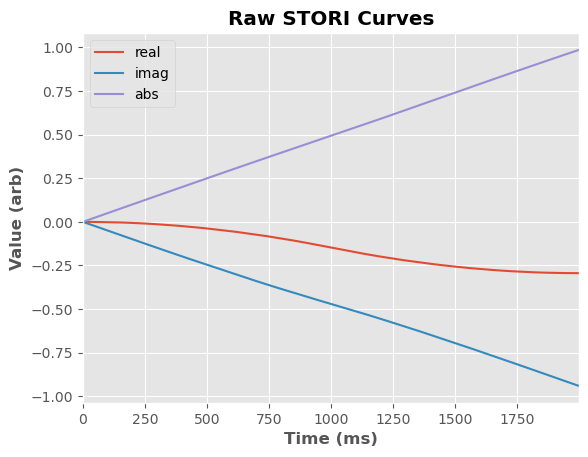

In [5]:
"""--------------------------------------------------------------------------------------------------------

    STEP 4: PLOT THE INITIAL STORI CURVES TO SEE THE EFFECTS OF THE FREQUENCY SHIFT AND FIT THE DATA

-------------------------------------------------------------------------------------------------------"""

#First we fit the magnitude/abs STORI curve (which would be how ion charge is estimated)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(times_ms/1000.0,  np.abs(raw_stori_values))

true_slope = 1000.0*amplitude/transient_length_ms
print('\nTrue/Expected Slope: {:.4f}'.format(true_slope))

print('\nMagnitude STORI Fit:')
print('Slope: {:.4f} ({:.2f}% Error)'.format(slope, 100.0*(slope-true_slope)/true_slope))
print('R^2: {:.4f}'.format(r_value*r_value))


downsampling_constant = 1000 #downsample to speed up plotting

plt.figure()
plt.title('Raw STORI Curves', weight='bold')
plt.plot(times_ms[::downsampling_constant], np.real(raw_stori_values[::downsampling_constant]),label='real')
plt.plot(times_ms[::downsampling_constant], np.imag(raw_stori_values[::downsampling_constant]), label='imag')
plt.plot(times_ms[::downsampling_constant], np.abs(raw_stori_values[::downsampling_constant]), label='abs')
plt.xlabel('Time (ms)', weight='bold')
plt.ylabel('Value (arb)', weight='bold')
plt.xlim(np.min(times_ms), np.max(times_ms))
plt.legend()
plt.show()

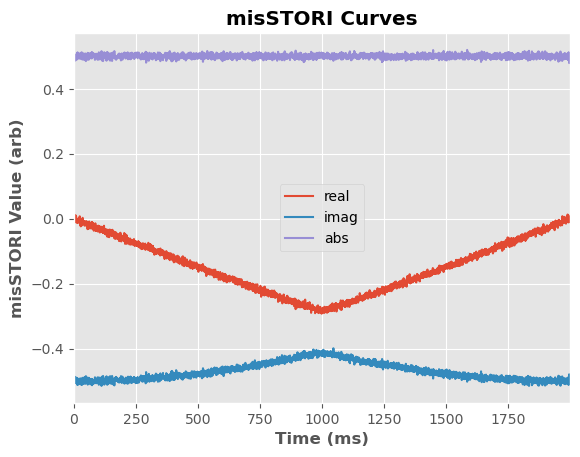

In [6]:
"""-------------------------------------------------------------------------------------------------------------------

    STEP 5: CALCULATE misSTORI VALUES
    
    There is clearly something that goes wrong in the raw STORI curves.  The real and imaginary parts have curved shapes,
    which is indicative of a mismatch between the STORI/reference frequency and the actual signal frequency.  Additionally,
    the magnitude mode STORI curve has a lower slope than it should, due these frequency errors.  This would result in an
    artificially low charge estimate for the ion, and therefore an artifically low absolute mass.  In a real world scenario,
    we would not know what the "true" slope should be, but the curved real/imaginary plots would be a telltale sign of
    frequency errors/shifting.  This would suggest that the magnitude mode curve might not be as straight/correct as it
    should be, and it could benefit from correcting the frequency issues.  This is where the "misSTORI" concept comes in.
    
    Let's proceed with the misSTORI calculations...

----------------------------------------------------------------------------------------------------------------------"""

#As the first step of the misSTORI calculations, we take the derivative of the complex STORI values.
#The data is smoothed to reduce noise and make the frequency shift more apparent
smoothingPoints=5000
misSTORI = np.diff(raw_stori_values)/(np.diff(times_ms)/1000.0)
misSTORI = uniform_filter1d(misSTORI, size=smoothingPoints)

plt.figure()
plt.title('misSTORI Curves', weight='bold')
plt.plot(times_ms[1::downsampling_constant], np.real(misSTORI[::downsampling_constant]),label='real')
plt.plot(times_ms[1::downsampling_constant], np.imag(misSTORI[::downsampling_constant]), label='imag')
plt.plot(times_ms[1::downsampling_constant], np.abs(misSTORI[::downsampling_constant]), label='abs')
plt.xlabel('Time (ms)', weight='bold')
plt.ylabel('misSTORI Value (arb)', weight='bold')
plt.xlim(np.min(times_ms), np.max(times_ms))
plt.legend()
plt.show()

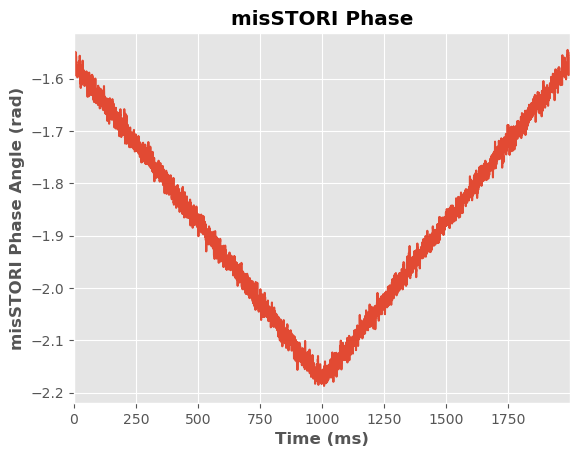

In [7]:
"""-------------------------------------------------------------------------------------------------------------------

    STEP 6: CALCULATE PHASE ANGLE OF misSTORI CURVE
    
    In the above graph, several things are apparent.  First, the real and imaginary misSTORI traces are never flat.
    This indicates that the original reference/STORI frequency is "incorrect" at all points in time.  Second, the shapes
    of the real and imaginary traces change significantly halfway through the transient.  This is indicative of the
    signal frequency changing at that point in time.  In order to quantify the frequency errors, we calculate
    the phase angle of the complex misSTORI values.  The slope of the resulting phase curve at any point in time will
    tell us the difference between the original STORI frequency and the real signal at that time.
    
----------------------------------------------------------------------------------------------------------------------"""

misSTORI_phase_rad = np.angle(misSTORI)

plt.figure()
plt.title('misSTORI Phase', weight='bold')
plt.plot(times_ms[1::downsampling_constant], misSTORI_phase_rad[::downsampling_constant])
plt.xlabel('Time (ms)', weight='bold')
plt.ylabel('misSTORI Phase Angle (rad)', weight='bold')
plt.xlim(np.min(times_ms), np.max(times_ms))
plt.show()

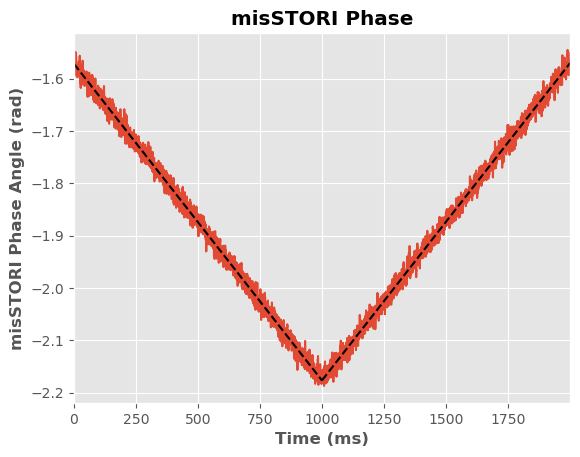


Slope 1 (0-1000.0s): -0.09634 Hz
"True" Frequency Difference: -0.09656 Hz

Slope 2 (1000.0-2000.0s): 0.09650 Hz
"True" Frequency Difference: 0.09656 Hz



In [9]:
"""-------------------------------------------------------------------------------------------------------------------

    STEP 7: FIT THE misSTORI PHASE SEGMENTS
    
    The misSTORI phase plot clearly has two regimes.  In the first section of the plot (before the frequency shift
    occurred), the slope is negative.  This indicates that the true signal frequency is lower than the reference/STORI
    frequency during that portion.  In the second portion of the plot, the slope inverts in sign, now becoming positive.
    The positive slope indicates that the signal frequency is higher than the reference/STORI frequency during that
    portion.  The magnitude of the two slopes is appropximately the same, indicating that the magnitude of the frequency
    error was similar during the two segments.  We can calculate the approximate frequency errors for the two segments
    by fitting them to straight lines.
    
    Since we know what the actual frequency error was in this artifical scenario, we can compared out calculated
    frequency errors to the "true" frequency errors.
    
----------------------------------------------------------------------------------------------------------------------"""

#First we fit the initial segment
slope1, intercept1, r_value, p_value, std_err = scipy.stats.linregress(times_ms[0:shift_index], misSTORI_phase_rad[0:shift_index])

#Then we fit the second segment
slope2, intercept2, r_value, p_value, std_err = scipy.stats.linregress(times_ms[shift_index:-2], misSTORI_phase_rad[shift_index:-1])

plt.figure()
plt.title('misSTORI Phase', weight='bold')
plt.plot(times_ms[1::downsampling_constant], misSTORI_phase_rad[::downsampling_constant])
plt.plot(times_ms[0:shift_index], intercept1+times_ms[0:shift_index]*slope1, '--', color='black')
plt.plot(times_ms[shift_index:-1], intercept2+times_ms[shift_index:-1]*slope2, '--', color='black')
plt.xlabel('Time (ms)', weight='bold')
plt.ylabel('misSTORI Phase Angle (rad)', weight='bold')
plt.xlim(np.min(times_ms), np.max(times_ms))
plt.show()


print('\nSlope 1 (0-{:.1f}s): {:.5f} Hz'.format(times_ms[shift_index],slope1*1000.0/(2.0*np.pi)))
print('"True" Frequency Difference: {:.5f} Hz'.format(1000.0*(starting_frequency_kHz - stori_frequency)))
print('\nSlope 2 ({:.1f}-{:.1f}s): {:.5f} Hz'.format(times_ms[shift_index],times_ms[-1], slope2*1000.0/(2.0*np.pi)))
print('"True" Frequency Difference: {:.5f} Hz\n'.format(1000.0*(ending_frequency_kHz - stori_frequency)))


In [10]:
"""-------------------------------------------------------------------------------------------------------------------

    STEP 8: PERFORM A SECOND STORI CALCULATION, FEEDING BACK THE misSTORI INFORMATION TO CORRECT FOR SHIFTS
    
    As shown above, the slopes of the two linear segments match the difference between the reference/STORI frequency
    and the ion frequency.  In the first portion of the graph, the slope is negative, because the signal frequency is
    lower than the reference/STORI frequency.  However, in the second portion of the graph, the slope is positive, because
    the signal frequency is higher than the reference/STORI frequency.

    Since the misSTORI phase plot clearly shows that the ion frequency is different from the reference/STORI frequency
    through the transient, we can re-do the STORI calculation, utilizing this information.  In this second round of STORI
    calculation, we will use different reference/STORI frequencies throughout the transient, to match what we found in the
    misSTORI phase plot.  Specifically, we will deviate from our initial reference/STORI frequency during sections 1 and
    2 by the amounts determined in the misSTORI phase fits above.  In the first portion of the re-calculation, we will use
    a reference/STORI frequency that is lower than our initial value by the "Slope 1" value above, and during the second
    portion we will use a reference/STORI frequency that is higher than our initial value by the "Slope 2" value above.
    Essentially, we are moving the STORI frequency over time to better match what was happening in the real ion signal,
    as opposed to the initial calculation, which just used single fixed frequency.  If done properly, this should result
    in straighter STORI curves (real, imaginary and magnitude), as we've properly accounted for the shifting nature of the
    ion signal.  Furthermore, we should have a more correct slope of the magnitude plot, which would result in a truer
    charge assignment.
    
    NOTE: This cell will take awhile to complete its calculations, as its written in a brute-force manner
    
----------------------------------------------------------------------------------------------------------------------"""

#this is the frequency we will use in the first portion of the corrected STORI curve, using the slope we calculated above 
freq1_kHz = stori_frequency + slope1/(2.0*np.pi)

#this is the frequency we will use in the second portion of the corrected STORI curve, using the slope we calculated above
freq2_kHz = stori_frequency + slope2/(2.0*np.pi)

#placeholder for corrected STORI values
corrected_stori_values = np.zeros(times_ms.size,dtype=np.complex128)

        
current_freq = freq1_kHz
timeDiff_ms = times_ms[1]-times_ms[0]
phase_buildup=0
updateSteps = 10
indicesPerUpdate = math.floor(times_ms.size/updateSteps)
numUpdates = 0

print('\nCalculating corrected STORI curves...\n')

#loop through all the time points
for i in range(0,times_ms.size):

    #we will use different reference/STORI frequencies, depending on the time
    if i<shift_index:
        current_freq = freq1_kHz
    else:
        current_freq = freq2_kHz
    
    #count the phase buildup from the previous time step's frequency
    phase_buildup = phase_buildup + timeDiff_ms*current_freq*2*np.pi

    # get what the phase buildup of the current frequency would have been
    current_freq_phase_buildup = times_ms[i]*current_freq*2*np.pi
    
    period_ms = 1.0/current_freq
    delta_phase = current_freq_phase_buildup - phase_buildup
    delta_phase_time_equivalent = -period_ms*delta_phase/(2*np.pi)
    
    scaling_factor = 1/(frequency.size)
    
    #do the correlations to the sin and cos waves with the proper phase shift
    sinCorr = transient_values[i]*np.sin(-2*np.pi*(times_ms[i]+delta_phase_time_equivalent)*current_freq)*scaling_factor
    cosCorr = transient_values[i]*np.cos(-2*np.pi*(times_ms[i]+delta_phase_time_equivalent)*current_freq)*scaling_factor


    #combine the sin/cos correlations into a complex number for the STORI output
    if i==0:
        corrected_stori_values[i] = complex(cosCorr,sinCorr)

    else:
        corrected_stori_values[i] = corrected_stori_values[i-1]+complex(cosCorr,sinCorr)

    if i%indicesPerUpdate ==0:
        print('{:.1f} % Complete Update ({:d}/{:d})'.format(100.0*numUpdates/updateSteps,i,times_ms.size))
        numUpdates=numUpdates+1
        
print('{:.1f} % Complete ({:d}/{:d} Points)'.format(100.0*numUpdates/updateSteps,times_ms.size,times_ms.size))       
print('\nFinished calculating corrected STORI curves.\n')


Calculating corrected STORI curves...

0.0 % Complete Update (0/10000000)
10.0 % Complete Update (1000000/10000000)
20.0 % Complete Update (2000000/10000000)
30.0 % Complete Update (3000000/10000000)
40.0 % Complete Update (4000000/10000000)
50.0 % Complete Update (5000000/10000000)
60.0 % Complete Update (6000000/10000000)
70.0 % Complete Update (7000000/10000000)
80.0 % Complete Update (8000000/10000000)
90.0 % Complete Update (9000000/10000000)
100.0 % Complete (10000000/10000000 Points)

Finished calculating corrected STORI curves.




True/Expected Slope: 0.5000

Magnitude STORI Fit:
Slope: 0.5002 (0.04% Error)
R^2: 1.0000


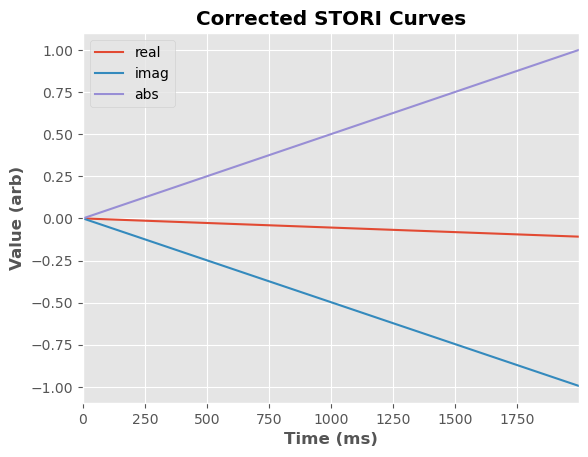

In [12]:
"""--------------------------------------------------------------------------------------------------------

    STEP 9: PLOT THE CORRECTED STORI CURVES AND FIT THE DATA, TO SEE IF THE CORRECTION WORKED

-------------------------------------------------------------------------------------------------------"""

#First we fit the magnitude/abs STORI curve (which would be how ion charge is estimated)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(times_ms/1000.0,  np.abs(corrected_stori_values))

print('\nTrue/Expected Slope: {:.4f}'.format(true_slope))

print('\nMagnitude STORI Fit:')
print('Slope: {:.4f} ({:.2f}% Error)'.format(slope, 100.0*(slope-true_slope)/true_slope))
print('R^2: {:.4f}'.format(r_value*r_value))

#NOTE: We downsample the data to speed up the plotting

downsampling_constant = 1000

plt.figure()
plt.title('Corrected STORI Curves', weight='bold')
plt.plot(times_ms[::downsampling_constant], np.real(corrected_stori_values[::downsampling_constant]),label='real')
plt.plot(times_ms[::downsampling_constant], np.imag(corrected_stori_values[::downsampling_constant]), label='imag')
plt.plot(times_ms[::downsampling_constant], np.abs(corrected_stori_values[::downsampling_constant]), label='abs')
plt.xlabel('Time (ms)', weight='bold')
plt.ylabel('Value (arb)', weight='bold')
plt.xlim(np.min(times_ms), np.max(times_ms))
plt.legend()
plt.show()

In [14]:
"""------------------------------------------------------------------------------------------------------------------

    As shown in the final figure and its associated fit, the misSTORI corrections resulted in a final, corrected
    STORI curve that has much straighter real, imaginary and magnitude curves.  Furthermore, the slope of the
    magnitude curve, which is used to estimate ion charge, has a much smaller error than the original, uncorrected
    STORI curve.  As such, the misSTORI methodology is able to improve the quality of charge measurements reported
    from STORI analyses when there are shifts in ion frequencies (e.g. from solvent loss during mass analysis).

---------------------------------------------------------------------------------------------------------------------"""

print('\nComplete.')


Complete.
